# Grain sizes counting and distribution testing

## Preprocessing

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# import ipympl
import imageio.v3 as iio
import skimage

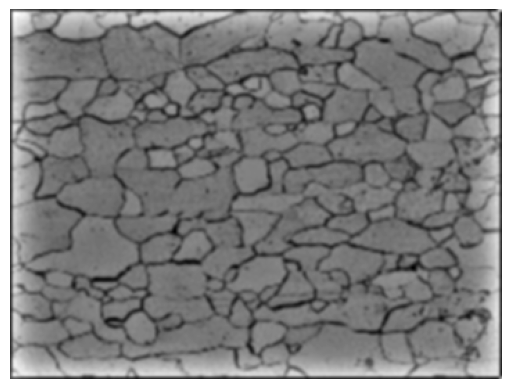

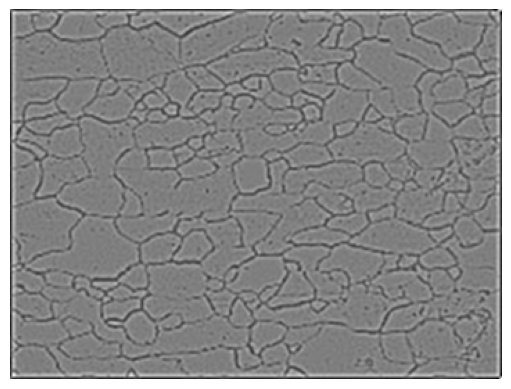

(267, 355)

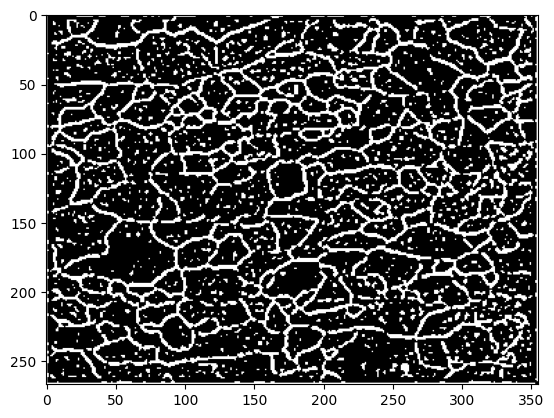

In [14]:
from skimage.filters import gaussian, median, difference_of_gaussians, laplace
from skimage.feature import canny
from skimage import exposure

image_original = iio.imread(uri="data/structure01.jpg")

# fig = plt.figure()
# fig.add_subplot(2, 2, 1)
# plt.imshow(image_original)
# # print(image)
# # image_original.shape
# gray_image = skimage.color.rgb2gray(image_original)
# fig.add_subplot(2, 2, 2)
# plt.imshow(gray_image)
# filtered_image = median(gray_image)
# fig.add_subplot(2, 2, 3)
# plt.imshow(filtered_image)
# image_canny = canny(filtered_image, 1.5)
# image = image_canny.copy()
# fig.add_subplot(2, 2, 4)
# plt.imshow(image, cmap='gray')
# plt.show(block=True)

gray_image = skimage.color.rgb2gray(image_original)
# fig, ax = plt.subplots()
# plt.axis('off')
# plt.imshow(gray_image, cmap='gray')
filtered_image = difference_of_gaussians(gray_image, 1, 12)
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(filtered_image, cmap='gray')
image_edges = laplace(filtered_image, 8)
image = image_edges.copy()
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.autoscale(tight=True)
plt.show()

p2, p98 = np.percentile(image, (2, 98))
img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
img_eq = exposure.equalize_hist(image)
img_eq[img_eq>0.25] = 1
img_eq[img_eq<=0.25] = 0
img_eq = 1 - img_eq
fig, ax = plt.subplots()
plt.imshow(img_eq, cmap='gray')
image = img_eq
image.shape

## Applicaion

### Grain sizes collecting

(array([60., 74., 88., 92., 78., 74., 67., 68., 42., 57., 29., 38., 31.,
        29., 17., 17., 14., 14., 17., 10., 22., 10.,  3.,  7.,  4.,  3.,
         5.,  2.,  4.,  2.,  1.,  0.,  3.,  4.,  1.,  1.,  0.,  0.,  1.,
         0.,  0.,  3.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 1.        ,  1.96825397,  2.93650794,  3.9047619 ,  4.87301587,
         5.84126984,  6.80952381,  7.77777778,  8.74603175,  9.71428571,
        10.68253968, 11.65079365, 12.61904762, 13.58730159, 14.55555556,
        15.52380952, 16.49206349, 17.46031746, 18.42857143, 19.3968254 ,
        20.36507937, 21.33333333, 22.3015873 , 23.26984127, 24.23809524,
        25.20634921, 26.17460317, 27.14285714, 28.11111111, 29.07936508,
        30.04761905, 31.01587302, 31.98412698, 32.95238095, 33.92063492,
        34.88888889, 35.85714286, 36.82539683, 37.79365079, 38.76190476,
        39.73015873, 40.6984127 , 41.66666667, 42.63492063,

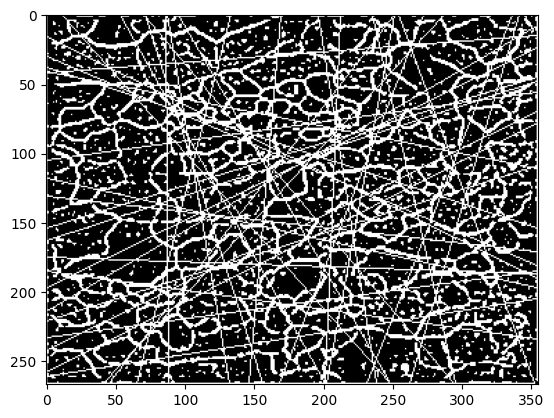

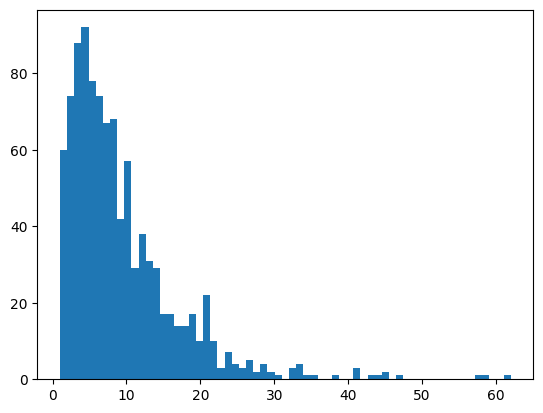

In [36]:
from skimage.draw import line
import random

def get_grains(pixels):
    peaks = pixels.copy()
    for i in range(3, len(pixels)-3):
        if not pixels[i] and pixels[i-1] and not pixels[i-2] and pixels[i+1] and not pixels[i+2]:
            peaks[i] = True
        else:
            if pixels[i] and not pixels[i-1] and pixels[i-2] and not pixels[i+1] and pixels[i+2]:
                peaks[i] = False
    peaks = np.flip(peaks)
    grains = []
    curr_len = 0
    for i in range(len(peaks)):
        if peaks[i]:
            if curr_len > 0:
                grains.append(curr_len)
            curr_len = 0
        else:
            curr_len += 1
    return grains

cuts_illustration = np.zeros(image.shape, np.uint8)
cuts_illustration = image.copy()
grains = []
desired_size = 1000
grain_border_width = 0
pseudorandomizer = np.random.RandomState(2021)
while len(grains) < desired_size:
    rand_r1 = random.randrange(image.shape[0])
    rand_c1 = random.randrange(image.shape[1])
    rand_r2 = random.randrange(image.shape[0])
    rand_c2 = random.randrange(image.shape[1])
    if pseudorandomizer.randint(0, 1000) < 500:
        rr, cc = line(rand_r1, 0, rand_r2, image.shape[1]-1)
    else:
        rr, cc = line(0, rand_c1, image.shape[0]-1, rand_c2)
    curr_line_pixels = image[rr, cc]
    cuts_illustration[rr, cc] = 1
    grain_candidates = get_grains(curr_line_pixels)
    for grain in grain_candidates:
        if grain > grain_border_width:
            grains.append(grain)

fig, ax = plt.subplots()
plt.imshow(cuts_illustration, cmap='gray')
fig, ax = plt.subplots()
grains = np.array(grains)
bins = max(grains) + 1
plt.hist(grains, density=False, bins=bins)


### Grain sizes distribution testing


Normaltest p-value is: 0.00 

We have evidence to reject the null hypothesis.


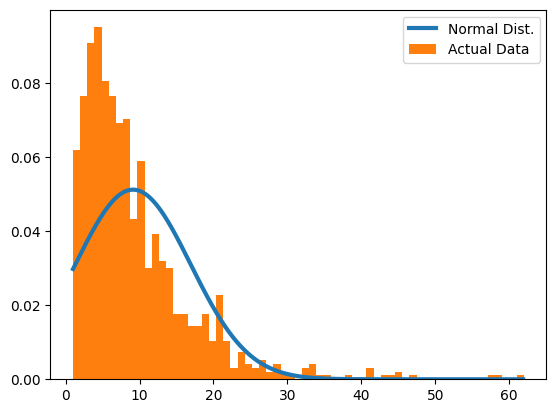

In [37]:
import scipy.stats as stats

def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

xs = np.arange(grains.min(), grains.max(), 0.1)
params = stats.norm.fit(grains)
fit = stats.norm.pdf(xs, *params)
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()

stat, p_val = stats.normaltest(grains)
print('\nNormaltest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)


KStest p-value is: 0.01 

We have evidence to reject the null hypothesis.


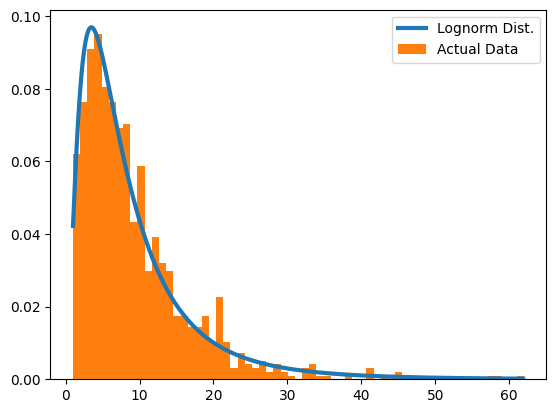

In [38]:
params = stats.lognorm.fit(grains)
fit = stats.lognorm.pdf(xs, *params)
plt.plot(xs, fit, label='Lognorm Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()

stat, p_val = stats.kstest(grains, 'lognorm', args=params)
print('\nKStest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

In [39]:
import scipy.stats as st

def get_best_distribution(data):
    dist_names = ["norm", "lognorm", "gamma", "beta", "expon", "exponnorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

best_dist, best_p, params = get_best_distribution(grains)


p value for norm = 3.0757190780027963e-22
p value for lognorm = 0.006318144329710705
p value for gamma = 1.7410482887864274e-24
p value for beta = 1.0441161691432488e-05
p value for expon = 4.835211736078567e-07
p value for exponnorm = 2.163459100649666e-07
Best fitting distribution: lognorm
Best p value: 0.006318144329710705
Parameters for the best fit: (0.7771398754449788, -0.43724606992629067, 7.160972898310565)
